In [1]:
import os
from shutil import copy2
from collections import Counter
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from PIL import Image as PILImage
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Rescaling
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import time
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping

#For Cross Validation 
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#For basic Keras model training
from tensorflow import keras
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Dropout

#For state-of-art pre-trained models
from tensorflow.keras import models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50, ResNet152V2, ResNet101
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7, EfficientNetB6, EfficientNetV2S, EfficientNetV2M
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

#For ArcFace
import math
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input, Softmax
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from IPython.display import Image as IPythonImage
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

/Users/yiyiluo/miniconda3/envs/capstone/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


**Check and remove corrupted images**

In [2]:
def delete_corrupted_images(directory):
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                continue

            file_path = os.path.join(root, filename)

            try:
                with PILImage.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError) as e:
                print(f"PIL cannot process {file_path}, deleting: {e}")
                os.remove(file_path)
                continue  

            try:
                image_bytes = tf.io.read_file(file_path)
                image = tf.io.decode_image(image_bytes, channels=3, expand_animations=False)
                image = tf.image.resize(image, [256, 256])
            except tf.errors.InvalidArgumentError as e:
                print(f"TensorFlow cannot process {file_path}, deleting: {e}")
                os.remove(file_path)

        for dirname in dirs:
            dir_path = os.path.join(root, dirname)
            if not os.listdir(dir_path):  
                print(f"Removing empty directory: {dir_path}")
                os.rmdir(dir_path)

directory = 'train_images'
delete_corrupted_images(directory)

In [50]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical", input_shape=(256, 256, 3)),  
        layers.RandomRotation(0.2),  
        layers.RandomZoom(0.2),  
        layers.RandomContrast(factor=0.1),  
        layers.RandomBrightness(factor=0.1),  
        layers.Resizing(280, 280),  
        layers.RandomCrop(height=256, width=256),  
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1), 
    ]
)


## **Part III: More advanced and pre-trained convolutional neural network models**

In [3]:
full_dataset_directory = "train_images"

image_counts = {}

for class_dir in os.listdir(full_dataset_directory):
    class_path = os.path.join(full_dataset_directory, class_dir)
    if os.path.isdir(class_path):
        image_counts[class_dir] = len([entry for entry in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, entry))])

top_500_classes = Counter(image_counts).most_common(500)

subset_directory = "subset_top_500_hotels"  
os.makedirs(subset_directory, exist_ok=True)

for class_dir, _ in top_500_classes:
    original_class_path = os.path.join(full_dataset_directory, class_dir)
    subset_class_path = os.path.join(subset_directory, class_dir)
    os.makedirs(subset_class_path, exist_ok=True)
    
    for image in os.listdir(original_class_path):
        src_image_path = os.path.join(original_class_path, image)
        dst_image_path = os.path.join(subset_class_path, image)
        copy2(src_image_path, dst_image_path)

print("The subset with the top 500 classes has been created.")

The subset with the top 500 classes has been created.


In [6]:
dataset_path = 'subset_top_500_hotels'
analyze_images(dataset_path)

Total number of hotels: 500
Minimum number of images in a hotel: 12
Maximum number of images in a hotel: 632
Average number of images per hotel: 27.01


<img width="700" alt="Screenshot 2024-02-11 at 5 20 24 PM" src="https://github.com/Yiyi-Luo/Capstone-Project-Hotel-Detection-to-Combat-Human-Trafficking/assets/149438809/ac53a188-a7c8-4ca5-98f5-b5ef7725470e">

In [9]:
subset_directory = 'subset_top_500_hotels'

subset_train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=subset_directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256,256),
    shuffle=True,
    seed=123,
    validation_split=0.3, 
    subset='training', 
    interpolation='bilinear', 
    follow_links=False,
    crop_to_aspect_ratio=False
)

subset_validation_test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=subset_directory,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.3,  
    subset='validation',  
    interpolation='bilinear',
    crop_to_aspect_ratio=False
)

total_batches = len(subset_validation_test_dataset)
batches_per_subset = total_batches // 2
subset_validation_dataset = subset_validation_test_dataset.take(batches_per_subset)
subset_test_dataset = subset_validation_test_dataset.skip(batches_per_subset)

Found 13504 files belonging to 500 classes.
Using 9453 files for training.
Found 13504 files belonging to 500 classes.
Using 4051 files for validation.


In [10]:
class_names = subset_train_dataset.class_names
num_classes = len(class_names)

## **Part IV: Our best model-EfficientB0: more tuning and incorporating ArcFace**

**Among all the pre-trained models, EfficientNetB0 stood out; we continue to use the EfficientNetB0 architecture as a base, leveraging transfer learning, regularization, and data augmentation to enhance performance on potentially complex datasets.**

In [13]:
def build_model(num_classes, input_shape=(256, 256, 3), l1_factor=0, l2_factor=0, dropout_rate=0, use_data_augmentation=False):
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    
    if use_data_augmentation:
        data_augmentation = tf.keras.Sequential([
            layers.RandomFlip("horizontal_and_vertical"),  
            layers.RandomRotation(0.2),  
            layers.RandomZoom(0.2),  
            layers.RandomContrast(factor=0.1),  
            layers.RandomBrightness(factor=0.1),  
            layers.Resizing(280, 280),  
            layers.RandomCrop(height=256, width=256),  
            layers.RandomTranslation(height_factor=0.1, width_factor=0.1), 
        ])
        x = data_augmentation(x)
    
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    if dropout_rate > 0:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_factor, l2=l2_factor))(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l1_l2(l1=l1_factor, l2=l2_factor))(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

def compile_and_fit(model, train_dataset, validation_dataset, epochs=50):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(
        monitor='val_loss',  
        patience=8,  
        restore_best_weights=True,  
        verbose=1 
    )
    
    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, verbose=1, callbacks=[early_stopping])
    return history

Epoch 1/50
197/197 [==============================] - 88s 434ms/step - loss: 5.1751 - accuracy: 0.1781 - val_loss: 4.7174 - val_accuracy: 0.2168
Epoch 2/50
197/197 [==============================] - 86s 430ms/step - loss: 3.5009 - accuracy: 0.3307 - val_loss: 4.1868 - val_accuracy: 0.3065
Epoch 3/50
197/197 [==============================] - 86s 429ms/step - loss: 2.0445 - accuracy: 0.5755 - val_loss: 3.9986 - val_accuracy: 0.3477
Epoch 4/50
197/197 [==============================] - 86s 429ms/step - loss: 1.0636 - accuracy: 0.7869 - val_loss: 3.9370 - val_accuracy: 0.3839
Epoch 5/50
197/197 [==============================] - 86s 430ms/step - loss: 0.5143 - accuracy: 0.9140 - val_loss: 3.9270 - val_accuracy: 0.3958
Epoch 6/50
197/197 [==============================] - 86s 430ms/step - loss: 0.2407 - accuracy: 0.9739 - val_loss: 3.9084 - val_accuracy: 0.4187
Epoch 7/50
197/197 [==============================] - 86s 430ms/step - loss: 0.1111 - accuracy: 0.9945 - val_loss: 3.8168 - val_ac

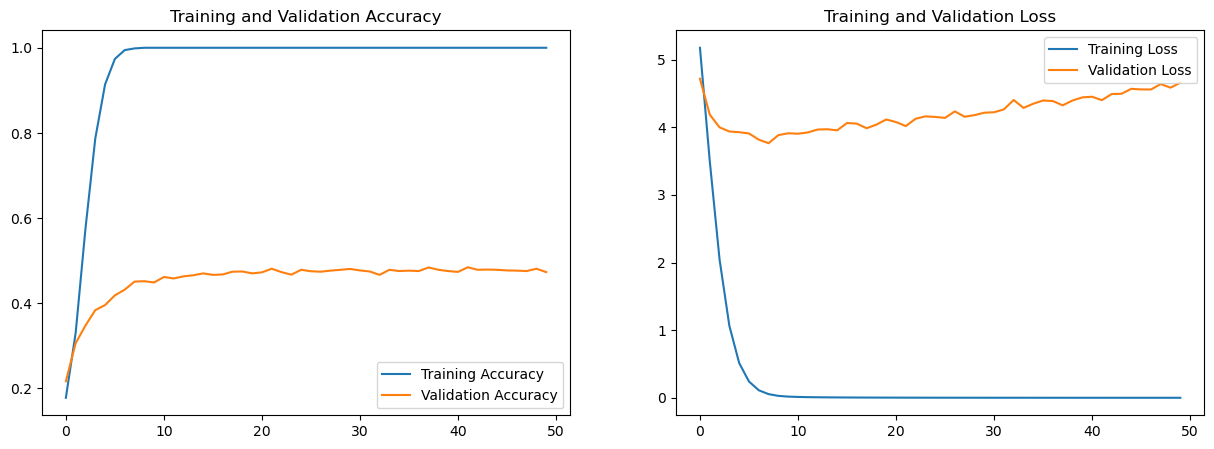

In [92]:
#EfficientNetB0 Model without augmentation, drop out or regularization
Efficient_base_model = build_model(num_classes)
history = compile_and_fit(base_model, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])
print(f'Average Validation Accuracy: {average_val_accuracy:.2f}')

Epoch 1/50
197/197 [==============================] - 97s 481ms/step - loss: 6.0743 - accuracy: 0.1444 - val_loss: 5.9128 - val_accuracy: 0.1677
Epoch 2/50
197/197 [==============================] - 95s 477ms/step - loss: 5.1693 - accuracy: 0.2198 - val_loss: 5.5218 - val_accuracy: 0.1974
Epoch 3/50
197/197 [==============================] - 95s 476ms/step - loss: 4.5993 - accuracy: 0.2746 - val_loss: 5.5132 - val_accuracy: 0.2004
Epoch 4/50
197/197 [==============================] - 95s 477ms/step - loss: 4.1902 - accuracy: 0.3393 - val_loss: 5.3526 - val_accuracy: 0.2341
Epoch 5/50
197/197 [==============================] - 95s 476ms/step - loss: 3.9014 - accuracy: 0.3818 - val_loss: 5.2758 - val_accuracy: 0.2445
Epoch 6/50
197/197 [==============================] - 95s 478ms/step - loss: 3.6318 - accuracy: 0.4308 - val_loss: 5.1916 - val_accuracy: 0.2664
Epoch 7/50
197/197 [==============================] - 95s 476ms/step - loss: 3.4399 - accuracy: 0.4698 - val_loss: 5.2614 - val_ac

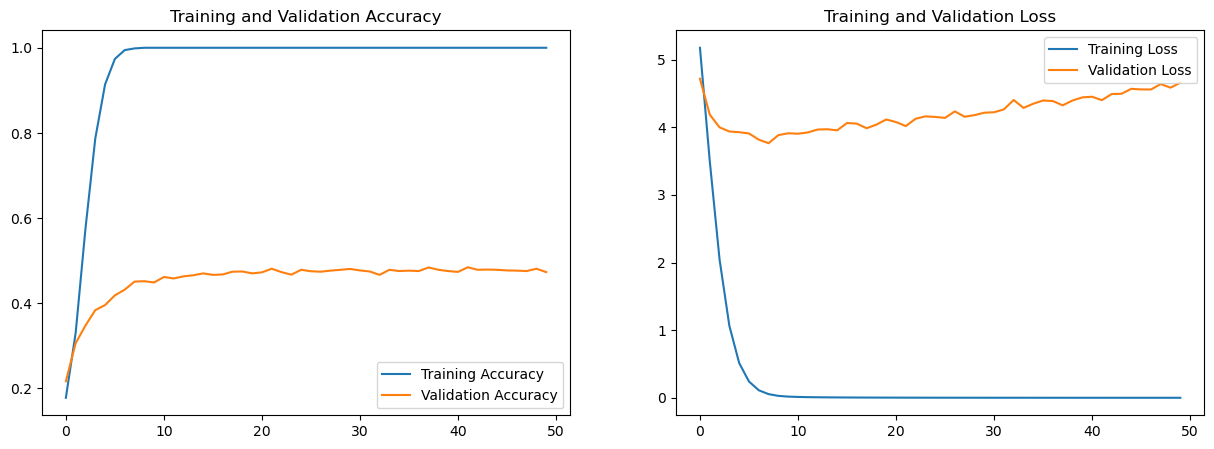

In [93]:
#EfficientNetB0 Model with l1+l2 Regularization, dropout and augmentation
model_with_reg = build_model(num_classes, l1_factor=1e-5, l2_factor=1e-4, dropout_rate=0.2, use_data_augmentation=True)
history_with_reg = compile_and_fit(model_with_reg, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])

Epoch 1/50
197/197 [==============================] - 87s 426ms/step - loss: 5.8355 - accuracy: 0.1794 - val_loss: 5.3827 - val_accuracy: 0.2168
Epoch 2/50
197/197 [==============================] - 84s 423ms/step - loss: 4.3678 - accuracy: 0.3181 - val_loss: 4.9465 - val_accuracy: 0.2932
Epoch 3/50
197/197 [==============================] - 85s 424ms/step - loss: 3.2360 - accuracy: 0.5162 - val_loss: 4.8366 - val_accuracy: 0.3363
Epoch 4/50
197/197 [==============================] - 85s 425ms/step - loss: 2.4728 - accuracy: 0.6953 - val_loss: 4.7331 - val_accuracy: 0.3750
Epoch 5/50
197/197 [==============================] - 85s 425ms/step - loss: 1.9683 - accuracy: 0.8354 - val_loss: 4.7397 - val_accuracy: 0.3929
Epoch 6/50
197/197 [==============================] - 84s 424ms/step - loss: 1.6689 - accuracy: 0.9172 - val_loss: 4.7499 - val_accuracy: 0.4013
Epoch 7/50
197/197 [==============================] - 85s 424ms/step - loss: 1.4901 - accuracy: 0.9615 - val_loss: 4.6659 - val_ac

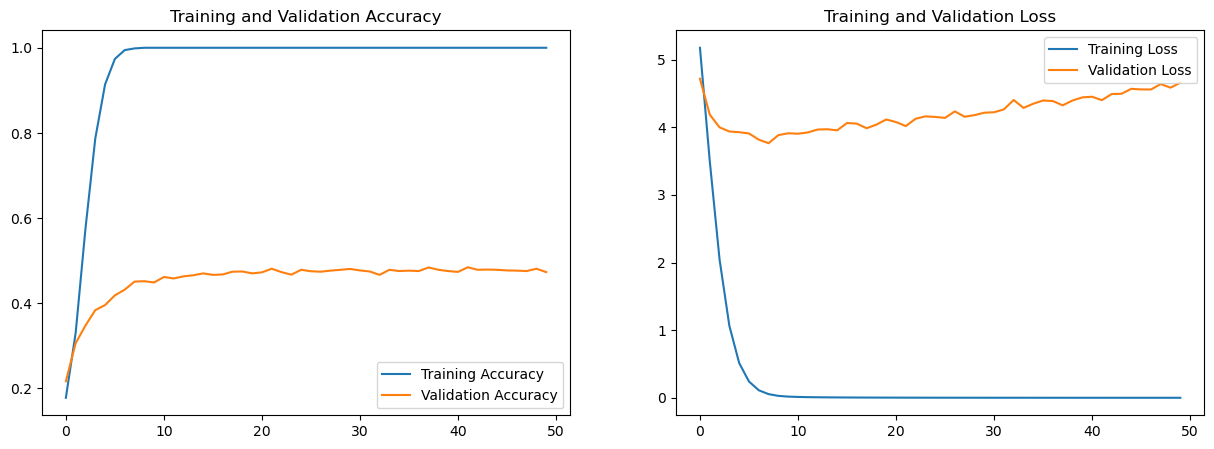

In [94]:
#EfficientNetB0 Model with l1+l2 Regularization
model_with_reg = build_model(num_classes, l1_factor=1e-5, l2_factor=1e-4)
history_with_reg = compile_and_fit(model_with_reg, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])

Epoch 1/50
197/197 [==============================] - 86s 422ms/step - loss: 5.2396 - accuracy: 0.1713 - val_loss: 4.7845 - val_accuracy: 0.2088
Epoch 2/50
197/197 [==============================] - 84s 420ms/step - loss: 3.7204 - accuracy: 0.3027 - val_loss: 4.2212 - val_accuracy: 0.2922
Epoch 3/50
197/197 [==============================] - 84s 419ms/step - loss: 2.3586 - accuracy: 0.5131 - val_loss: 4.0464 - val_accuracy: 0.3333
Epoch 4/50
197/197 [==============================] - 84s 420ms/step - loss: 1.3975 - accuracy: 0.7065 - val_loss: 3.9571 - val_accuracy: 0.3690
Epoch 5/50
197/197 [==============================] - 84s 421ms/step - loss: 0.8081 - accuracy: 0.8387 - val_loss: 4.0053 - val_accuracy: 0.3934
Epoch 6/50
197/197 [==============================] - 84s 423ms/step - loss: 0.4670 - accuracy: 0.9172 - val_loss: 3.9411 - val_accuracy: 0.4107
Epoch 7/50
197/197 [==============================] - 84s 421ms/step - loss: 0.2831 - accuracy: 0.9584 - val_loss: 3.9097 - val_ac

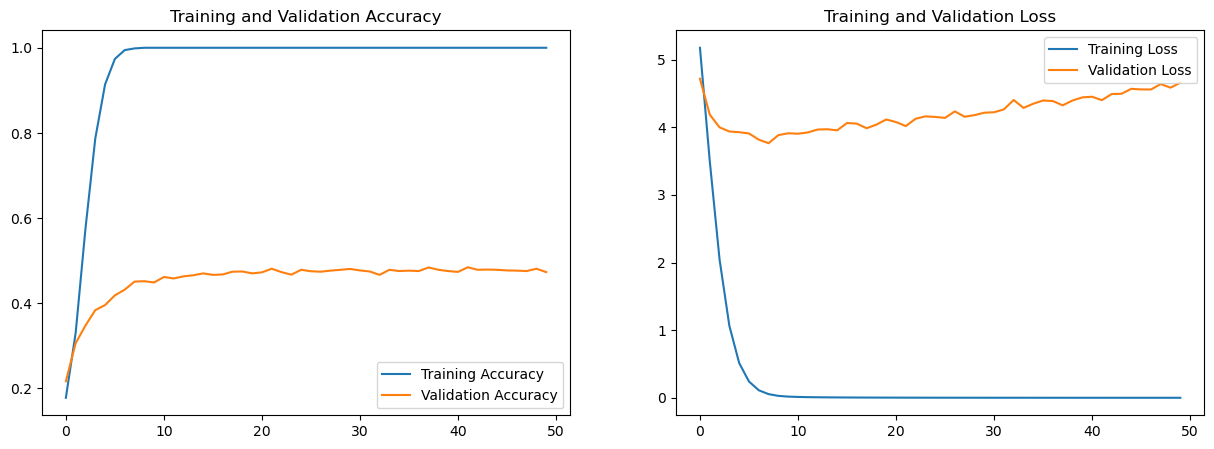

In [95]:
#EfficientNetB0 Model with dropout (0.2)
model_with_reg = build_model(num_classes, dropout_rate=0.2)
history_with_reg = compile_and_fit(model_with_reg, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])

Epoch 1/50
197/197 [==============================] - 95s 470ms/step - loss: 5.3838 - accuracy: 0.1455 - val_loss: 5.1783 - val_accuracy: 0.1627
Epoch 2/50
197/197 [==============================] - 93s 468ms/step - loss: 4.3594 - accuracy: 0.2301 - val_loss: 4.8396 - val_accuracy: 0.1939
Epoch 3/50
197/197 [==============================] - 93s 467ms/step - loss: 3.5861 - accuracy: 0.3118 - val_loss: 4.5961 - val_accuracy: 0.2376
Epoch 4/50
197/197 [==============================] - 93s 469ms/step - loss: 3.0371 - accuracy: 0.3896 - val_loss: 4.5333 - val_accuracy: 0.2426
Epoch 5/50
197/197 [==============================] - 93s 468ms/step - loss: 2.5702 - accuracy: 0.4645 - val_loss: 4.5568 - val_accuracy: 0.2445
Epoch 6/50
197/197 [==============================] - 93s 468ms/step - loss: 2.2149 - accuracy: 0.5243 - val_loss: 4.4283 - val_accuracy: 0.2654
Epoch 7/50
197/197 [==============================] - 93s 467ms/step - loss: 1.9049 - accuracy: 0.5765 - val_loss: 4.4406 - val_ac

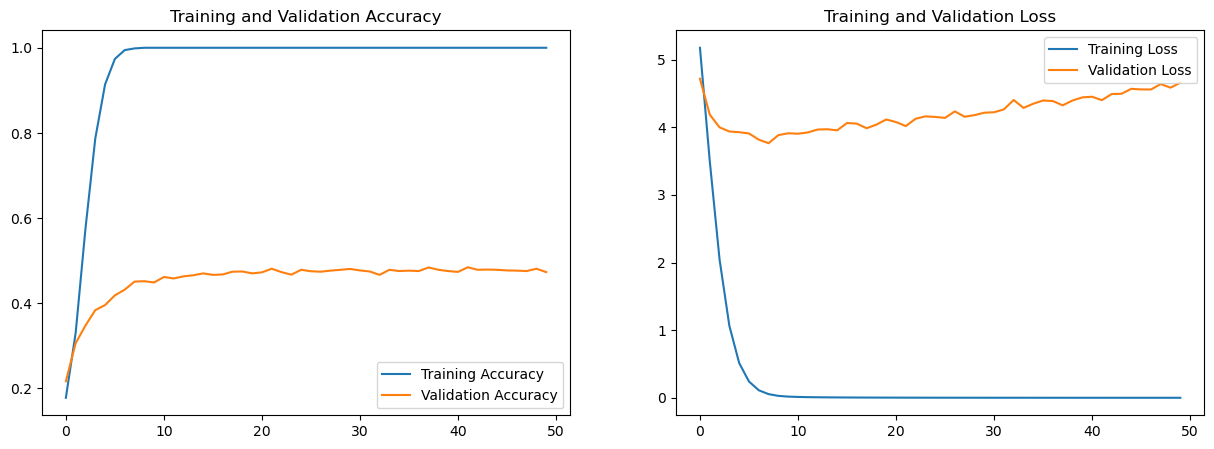

In [96]:
#EfficientNetB0 Model with augmentation
model_with_reg = build_model(num_classes, use_data_augmentation=True)
history_with_reg = compile_and_fit(model_with_reg, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])

Epoch 1/50
197/197 [==============================] - 84s 417ms/step - loss: 5.9272 - accuracy: 0.1708 - val_loss: 5.4467 - val_accuracy: 0.2168
Epoch 2/50
197/197 [==============================] - 83s 415ms/step - loss: 4.5884 - accuracy: 0.2885 - val_loss: 5.0392 - val_accuracy: 0.2803
Epoch 3/50
197/197 [==============================] - 83s 416ms/step - loss: 3.5430 - accuracy: 0.4544 - val_loss: 4.8693 - val_accuracy: 0.3269
Epoch 4/50
197/197 [==============================] - 83s 415ms/step - loss: 2.8033 - accuracy: 0.6219 - val_loss: 4.7714 - val_accuracy: 0.3676
Epoch 5/50
197/197 [==============================] - 83s 414ms/step - loss: 2.3183 - accuracy: 0.7491 - val_loss: 4.8376 - val_accuracy: 0.3705
Epoch 6/50
197/197 [==============================] - 83s 416ms/step - loss: 2.0095 - accuracy: 0.8297 - val_loss: 4.7621 - val_accuracy: 0.3988
Epoch 7/50
197/197 [==============================] - 83s 415ms/step - loss: 1.8086 - accuracy: 0.8933 - val_loss: 4.7892 - val_ac

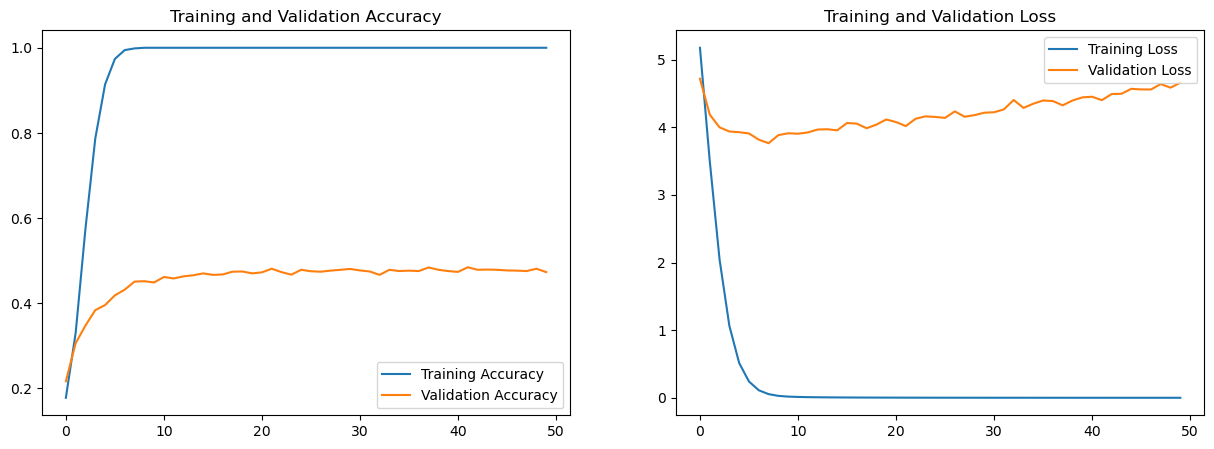

In [97]:
#EfficientNetB0 Model with l1+l2 Regularization and dropout 
model_with_reg = build_model(num_classes, l1_factor=1e-5, l2_factor=1e-4, dropout_rate=0.2)
history_with_reg = compile_and_fit(model_with_reg, subset_train_dataset, subset_validation_dataset)
plot_training_history(history)
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])

**Adjust the batch size from 48 to 32: Smaller batch sizes could provide a regularizing effect and more stable convergence.**

**Experimenting with adding more dropout layers on the model**

In [37]:
def build_model_dropout(num_classes, input_shape=(256, 256, 3), l2_factor=0, dropout_rate=0.1, use_data_augmentation=False):
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    
    if use_data_augmentation:
        data_augmentation = tf.keras.Sequential([
            layers.RandomFlip("horizontal_and_vertical"),
            layers.RandomRotation(0.5),
            layers.RandomZoom(0.5),
            layers.RandomContrast(factor=0.5),
            layers.RandomBrightness(factor=0.5),
            layers.Resizing(280, 280),
            layers.RandomCrop(height=256, width=256),
            layers.RandomTranslation(height_factor=0.5, width_factor=0.5),
        ])
        x = data_augmentation(x)
    
    x = base_model(x, training=False)
    
    # Add dropout after the base model
    if dropout_rate > 0:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Optionally add dropout here again if desired
    if dropout_rate > 0:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(l2_factor))(x)
    
    # Add dropout before the final layer
    if dropout_rate > 0:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(l2_factor))(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [31]:
model_with_3_dropout = build_model_dropout(num_classes, l2_factor=0, dropout_rate = 0.15)
history_with_reg = compile_and_fit(model_with_3_dropout, subset_train_dataset, subset_validation_dataset) 
average_val_accuracy = sum(history_with_reg.history['val_accuracy']) / len(history_with_reg.history['val_accuracy'])
print(f'Average Validation Accuracy: {average_val_accuracy:.2f}')

Epoch 1/50
296/296 [==============================] - 81s 266ms/step - loss: 5.2551 - accuracy: 0.1694 - val_loss: 4.8284 - val_accuracy: 0.1994
Epoch 2/50
296/296 [==============================] - 80s 266ms/step - loss: 3.8144 - accuracy: 0.2846 - val_loss: 4.3679 - val_accuracy: 0.2748
Epoch 3/50
296/296 [==============================] - 82s 273ms/step - loss: 2.4888 - accuracy: 0.4741 - val_loss: 4.1320 - val_accuracy: 0.3095
Epoch 4/50
296/296 [==============================] - 84s 282ms/step - loss: 1.5259 - accuracy: 0.6545 - val_loss: 4.0214 - val_accuracy: 0.3507
Epoch 5/50
296/296 [==============================] - 91s 306ms/step - loss: 0.9033 - accuracy: 0.7995 - val_loss: 4.0386 - val_accuracy: 0.3755
Epoch 6/50
296/296 [==============================] - 106s 356ms/step - loss: 0.5552 - accuracy: 0.8763 - val_loss: 4.1325 - val_accuracy: 0.3874
Epoch 7/50
296/296 [==============================] - 104s 349ms/step - loss: 0.3428 - accuracy: 0.9325 - val_loss: 4.1520 - val_

In [33]:
model_with_3_dropout = build_model_dropout(num_classes, l2_factor=0, dropout_rate = 0.1)
history_with_reg = compile_and_fit(model_with_3_dropout, subset_train_dataset, subset_validation_dataset) 
average_val_accuracy = sum(history_with_reg.history['val_accuracy']) / len(history_with_reg.history['val_accuracy'])
print(f'Average Validation Accuracy: {average_val_accuracy:.2f}')

Epoch 1/50
296/296 [==============================] - 80s 263ms/step - loss: 5.2236 - accuracy: 0.1745 - val_loss: 4.7705 - val_accuracy: 0.2138
Epoch 2/50
296/296 [==============================] - 78s 262ms/step - loss: 3.6682 - accuracy: 0.3020 - val_loss: 4.3584 - val_accuracy: 0.2743
Epoch 3/50
296/296 [==============================] - 78s 263ms/step - loss: 2.2416 - accuracy: 0.5216 - val_loss: 4.1837 - val_accuracy: 0.3249
Epoch 4/50
296/296 [==============================] - 79s 264ms/step - loss: 1.2826 - accuracy: 0.7130 - val_loss: 4.1214 - val_accuracy: 0.3571
Epoch 5/50
296/296 [==============================] - 79s 266ms/step - loss: 0.7125 - accuracy: 0.8457 - val_loss: 4.1613 - val_accuracy: 0.3839
Epoch 6/50
296/296 [==============================] - 80s 268ms/step - loss: 0.3980 - accuracy: 0.9217 - val_loss: 4.2051 - val_accuracy: 0.3894
Epoch 7/50
296/296 [==============================] - 81s 270ms/step - loss: 0.2350 - accuracy: 0.9579 - val_loss: 4.1819 - val_ac

In [34]:
model_with_3_dropout = build_model_dropout(num_classes, l2_factor=1e-5, dropout_rate = 0.15)
history_with_reg = compile_and_fit(model_with_3_dropout, subset_train_dataset, subset_validation_dataset) 
average_val_accuracy = sum(history_with_reg.history['val_accuracy']) / len(history_with_reg.history['val_accuracy'])
print(f'Average Validation Accuracy: {average_val_accuracy:.2f}')

Epoch 1/50
296/296 [==============================] - 84s 279ms/step - loss: 5.2842 - accuracy: 0.1700 - val_loss: 4.8643 - val_accuracy: 0.2088
Epoch 2/50
296/296 [==============================] - 83s 279ms/step - loss: 3.8878 - accuracy: 0.2833 - val_loss: 4.4360 - val_accuracy: 0.2624
Epoch 3/50
296/296 [==============================] - 84s 281ms/step - loss: 2.6014 - accuracy: 0.4722 - val_loss: 4.1869 - val_accuracy: 0.3189
Epoch 4/50
296/296 [==============================] - 85s 284ms/step - loss: 1.6702 - accuracy: 0.6497 - val_loss: 4.1168 - val_accuracy: 0.3477
Epoch 5/50
296/296 [==============================] - 86s 289ms/step - loss: 1.0725 - accuracy: 0.7901 - val_loss: 4.1590 - val_accuracy: 0.3740
Epoch 6/50
296/296 [==============================] - 88s 293ms/step - loss: 0.7286 - accuracy: 0.8701 - val_loss: 4.1377 - val_accuracy: 0.3953
Epoch 7/50
296/296 [==============================] - 86s 289ms/step - loss: 0.5328 - accuracy: 0.9216 - val_loss: 4.1244 - val_ac

In [35]:
best_model = build_model_dropout(num_classes, l2_factor=1e-4, dropout_rate = 0.1)
history_with_reg = compile_and_fit(best_model, subset_train_dataset, subset_validation_dataset) 
average_val_accuracy = sum(history_with_reg.history['val_accuracy']) / len(history_with_reg.history['val_accuracy'])
print(f'Average Validation Accuracy: {average_val_accuracy:.2f}')

Epoch 1/50
296/296 [==============================] - 89s 293ms/step - loss: 5.4814 - accuracy: 0.1742 - val_loss: 5.0795 - val_accuracy: 0.2118
Epoch 2/50
296/296 [==============================] - 88s 295ms/step - loss: 4.1093 - accuracy: 0.3022 - val_loss: 4.7419 - val_accuracy: 0.2877
Epoch 3/50
296/296 [==============================] - 89s 299ms/step - loss: 2.9553 - accuracy: 0.4985 - val_loss: 4.6331 - val_accuracy: 0.3323
Epoch 4/50
296/296 [==============================] - 90s 303ms/step - loss: 2.1339 - accuracy: 0.6857 - val_loss: 4.5968 - val_accuracy: 0.3581
Epoch 5/50
296/296 [==============================] - 87s 291ms/step - loss: 1.6538 - accuracy: 0.8146 - val_loss: 4.6565 - val_accuracy: 0.3681
Epoch 6/50
296/296 [==============================] - 87s 292ms/step - loss: 1.3806 - accuracy: 0.8895 - val_loss: 4.5428 - val_accuracy: 0.4043
Epoch 7/50
296/296 [==============================] - 88s 295ms/step - loss: 1.2046 - accuracy: 0.9387 - val_loss: 4.5292 - val_ac

In [36]:
model_with_3_dropout = build_model_dropout(num_classes, l2_factor=1e-5, dropout_rate = 0.1)
history_with_reg = compile_and_fit(model_with_3_dropout, subset_train_dataset, subset_validation_dataset) 
average_val_accuracy = sum(history_with_reg.history['val_accuracy']) / len(history_with_reg.history['val_accuracy'])
print(f'Average Validation Accuracy: {average_val_accuracy:.2f}')

Epoch 1/50
296/296 [==============================] - 95s 313ms/step - loss: 5.2387 - accuracy: 0.1759 - val_loss: 4.8070 - val_accuracy: 0.2153
Epoch 2/50
296/296 [==============================] - 94s 316ms/step - loss: 3.6972 - accuracy: 0.3070 - val_loss: 4.3209 - val_accuracy: 0.2703
Epoch 3/50
296/296 [==============================] - 94s 316ms/step - loss: 2.3070 - accuracy: 0.5252 - val_loss: 4.2048 - val_accuracy: 0.3194
Epoch 4/50
296/296 [==============================] - 95s 317ms/step - loss: 1.3775 - accuracy: 0.7205 - val_loss: 4.1200 - val_accuracy: 0.3606
Epoch 5/50
296/296 [==============================] - 96s 322ms/step - loss: 0.8226 - accuracy: 0.8517 - val_loss: 4.0741 - val_accuracy: 0.3805
Epoch 6/50
296/296 [==============================] - 96s 323ms/step - loss: 0.5341 - accuracy: 0.9270 - val_loss: 4.1187 - val_accuracy: 0.4008
Epoch 7/50
296/296 [==============================] - 96s 323ms/step - loss: 0.3839 - accuracy: 0.9582 - val_loss: 4.1139 - val_ac

In [38]:
model_with_3_dropout = build_model_dropout(num_classes, l2_factor=0, dropout_rate = 0.1, use_data_augmentation=True)
history_with_reg = compile_and_fit(model_with_3_dropout, subset_train_dataset, subset_validation_dataset) 
average_val_accuracy = sum(history_with_reg.history['val_accuracy']) / len(history_with_reg.history['val_accuracy'])
print(f'Average Validation Accuracy: {average_val_accuracy:.2f}')

Epoch 1/50
296/296 [==============================] - 107s 355ms/step - loss: 5.7344 - accuracy: 0.0932 - val_loss: 5.6474 - val_accuracy: 0.0908
Epoch 2/50
296/296 [==============================] - 106s 354ms/step - loss: 5.3943 - accuracy: 0.1266 - val_loss: 5.5266 - val_accuracy: 0.1290
Epoch 3/50
296/296 [==============================] - 106s 356ms/step - loss: 5.1848 - accuracy: 0.1397 - val_loss: 5.4463 - val_accuracy: 0.1453
Epoch 4/50
296/296 [==============================] - 105s 352ms/step - loss: 5.0404 - accuracy: 0.1548 - val_loss: 5.2811 - val_accuracy: 0.1716
Epoch 5/50
296/296 [==============================] - 106s 354ms/step - loss: 4.9113 - accuracy: 0.1633 - val_loss: 5.1920 - val_accuracy: 0.1751
Epoch 6/50
296/296 [==============================] - 105s 353ms/step - loss: 4.7907 - accuracy: 0.1748 - val_loss: 5.2407 - val_accuracy: 0.1791
Epoch 7/50
296/296 [==============================] - 104s 349ms/step - loss: 4.7237 - accuracy: 0.1766 - val_loss: 5.1509 -

In [40]:
best_model = build_model_dropout(num_classes, l2_factor=1e-4, dropout_rate = 0.1)
best_model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 8, 8, 1280)        4049571   
 )                                                               
                                                                 
 dropout_38 (Dropout)        (None, 8, 8, 1280)        0         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 7 (GlobalAveragePooling2D)                                      
                                                                 
 dropout_39 (Dropout)        (None, 1280)              0         
                                                                 
 dense_32 (Dense)            (None, 1024)              131

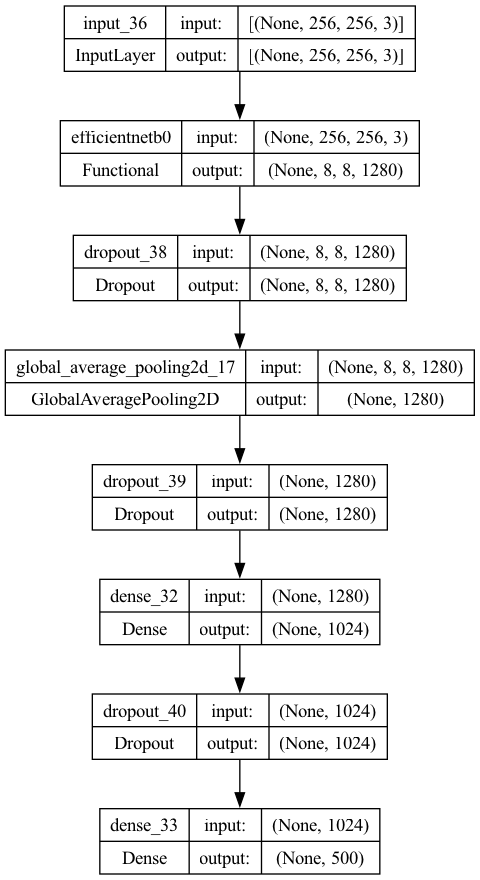

In [42]:
os.environ['PATH'] += os.pathsep + '/opt/homebrew/bin'
plot_model(best_model, to_file='model_architecture.png', show_shapes=True)
IPythonImage(filename='model_architecture.png')

In [44]:
best_model = build_model_dropout(num_classes, l2_factor=1e-4, dropout_rate=0.1)
history_with_reg = compile_and_fit(best_model, subset_train_dataset, subset_validation_dataset)
test_loss, test_accuracy = best_model.evaluate(subset_test_dataset)
print(f'Test Accuracy: {test_accuracy:.2f}')

Epoch 1/50
296/296 [==============================] - 162s 534ms/step - loss: 5.4654 - accuracy: 0.1766 - val_loss: 5.0578 - val_accuracy: 0.2227
Epoch 2/50
296/296 [==============================] - 155s 521ms/step - loss: 4.1188 - accuracy: 0.3055 - val_loss: 4.7243 - val_accuracy: 0.2842
Epoch 3/50
296/296 [==============================] - 158s 531ms/step - loss: 2.9437 - accuracy: 0.5031 - val_loss: 4.5815 - val_accuracy: 0.3284
Epoch 4/50
296/296 [==============================] - 159s 534ms/step - loss: 2.1364 - accuracy: 0.6847 - val_loss: 4.5355 - val_accuracy: 0.3631
Epoch 5/50
296/296 [==============================] - 160s 536ms/step - loss: 1.6507 - accuracy: 0.8101 - val_loss: 4.4976 - val_accuracy: 0.3844
Epoch 6/50
296/296 [==============================] - 154s 517ms/step - loss: 1.3743 - accuracy: 0.8932 - val_loss: 4.5159 - val_accuracy: 0.4028
Epoch 7/50
296/296 [==============================] - 154s 516ms/step - loss: 1.1953 - accuracy: 0.9438 - val_loss: 4.4509 -